TensorFlow 'raw' :: MNIST MLP
==============================

This is a quick illustration of a single-layer network training on the MNIST data.

( Credit for the original workbook : Aymeric Damien :: https://github.com/aymericdamien/TensorFlow-Examples )

In [27]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle

In [28]:
# Seed for reproducibility
np.random.seed(42)

### Get the MNIST data
Put it into useful subsets, and show some of it as a sanity check

In [31]:
# Download the MNIST digits dataset (only if not present locally)
import os
import urllib.request 

mnist_data = '../datasets' 
mnist_pkl_gz = mnist_data+'/mnist.pkl.gz'

if not os.path.isfile(mnist_pkl_gz):
    if not os.path.exists(mnist_data):
        os.makedirs(mnist_data)
    print("Downloading MNIST data file")
    urllib.request.urlretrieve(
        'http://deeplearning.net/data/mnist/mnist.pkl.gz', 
        mnist_pkl_gz)

print("MNIST data file available locally")

MNIST data file available locally


In [4]:
# Load training and test splits as numpy arrays
train, val, test = pickle.load(gzip.open(mnist_pkl_gz), encoding='iso-8859-1')

X_train, y_train = train
X_val, y_val = val
X_test, y_test = test

In [5]:
# The original 28x28 pixel images are flattened into 784 dimensional feature vectors
X_train.shape

(50000, 784)

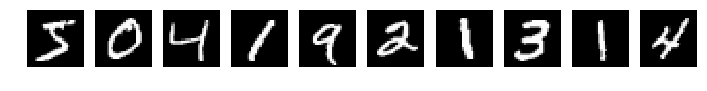

In [6]:
# Plot the first few examples 
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.axis('off')

### Create the Network


In [7]:
# Network Parameters
n_input    = 784 # MNIST data input (img shape: 28*28)
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_classes  = 10 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float32", [None, n_input],   name='x_input')
#y = tf.placeholder("int32", [None, n_classes], name='y_target')  # originally, a one-hot label
y = tf.placeholder("int32", [ None, ], name='y_target')  # This is the label index instead

In [8]:
# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['h1'])
    layer_1 = tf.nn.relu(layer_1)
    
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['h2'])
    layer_2 = tf.nn.relu(layer_2)
    
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [9]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'h1': tf.Variable(tf.random_normal([n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
logits = multilayer_perceptron(x, weights, biases)
#pred = tf.argmax(logits, axis=1)  # being deprecated
pred = tf.arg_max(logits, 1)
#pred = tf.reshape( tf.arg_max(logits, 1), [-1])

### Set up the Loss Function
So that we can perform Gradient Descent to improve the networks' parameters during training

In [10]:
# Define optimizer for the labels (expressed as a onehot encoding)
labels = tf.one_hot(indices=y, depth=10)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))

### Set up the Training Function


In [11]:
# Parameters for the training phase
learning_rate = 0.001
TRAINING_EPOCHS = 10
BATCH_SIZE = 100
display_step = 1

In [12]:
# Define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
#optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

### Set up the Initializer
NB: Do this after creating all the variables (including those inplicitly create in, say AdamOptimizer) since this figures out all the variables that need initializing at the point it is defined, apparently.

In [13]:
# Define an 'op' that initializes the variables
init = tf.global_variables_initializer()

### Batching of Training
For efficiency, we operate on data in batches, so that (for instance) a GPU can operate on multiple examples simultaneously

In [14]:
# We'll choose a batch size, and calculate the number of batches in an "epoch"
# (approximately one pass through the data).
N_BATCHES = len(X_train) // BATCH_SIZE
#N_VAL_BATCHES = len(X_val) // BATCH_SIZE

In [15]:
# For training, we want to sample examples at random in small batches
def batch_gen(X_, y_, N):
    while True:
        idx = np.random.choice(len(y_), N)
        yield X_[idx], y_[idx]

In [16]:
# Minibatch generator(s) for the training and validation sets
train_batches = batch_gen(X_train, y_train, BATCH_SIZE)
#val_batches = batch_gen(X_val, y_val, BATCH_SIZE)

0


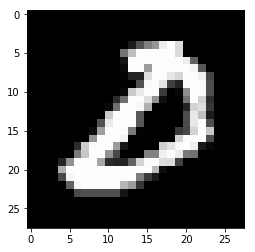

In [17]:
# Try sampling from the batch generator.
# Plot an image and corresponding label from the training batcher to verify they match.
X_batch, y_batch = next(train_batches)
plt.imshow(X_batch[0].reshape((28, 28)), cmap='gray', interpolation='nearest')
print(y_batch[0])

3


((10000, 784), (10000,))

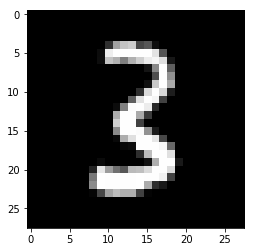

In [18]:
# Plot an image and corresponding label from the validation set to verify they match.
X_batch, y_batch = X_val, y_val
plt.imshow(X_batch[0].reshape((28, 28)), cmap='gray', interpolation='nearest')
print(y_batch[0])
X_batch.shape, y_batch.shape, 

### Test function to check final accuracy

In [19]:
#correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))  # with one-hots
correct_prediction = tf.equal(pred, tf.cast(y, tf.int64))  # with indices

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float32"))

### Finally, the Training...
For each epoch, we call the training function N_BATCHES times, accumulating an estimate of the training loss and accuracy.

* Then we evaluate the accuracy on the validation set.

TODO : Print out the ratio of loss in the validation set vs the training set to help recognize overfitting.

In [20]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)  # Running this 'op' initialises the network weights

    # Training cycle
    for epoch in range(TRAINING_EPOCHS):
        avg_cost = 0.
        
        # Loop over all batches
        for _ in range(N_BATCHES):
            batch_x, batch_y = next(train_batches)
            #print(batch_x.shape, batch_y.shape)
            
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x:batch_x, y:batch_y})
            
            # Compute average loss
            avg_cost += c / N_BATCHES
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=","{:.2f}".format(avg_cost))
    print("Optimization Finished!")

    # Test model
    accuracy_, y_, pred_  = sess.run([accuracy, y, pred ], feed_dict={x:X_val[0:10], y:y_val[0:10] })
    print("Validation Accuracy: %.2f%% for first 10 examples"  % ( 100. * accuracy_, ))
    #print(y_)
    #print(pred_)
    print("Validation Accuracy: %.2f%%"  % ( 100. * accuracy.eval({ x: X_val,  y: y_val, }),))
    
print("DONE")

Epoch: 0001 cost= 163.39
Epoch: 0002 cost= 41.99
Epoch: 0003 cost= 24.74
Epoch: 0004 cost= 18.33
Epoch: 0005 cost= 13.38
Epoch: 0006 cost= 9.89
Epoch: 0007 cost= 7.70
Epoch: 0008 cost= 5.69
Epoch: 0009 cost= 4.40
Epoch: 0010 cost= 3.54
Optimization Finished!
Validation Accuracy: 80.00% for first 10 examples
Validation Accuracy: 93.66%
DONE


In [21]:
# This proves that when the sessions are done, the network is thrown away...
# with tf.Session() as sess:
#     accuracy_, y_, pred_ = sess.run([accuracy, y, pred], feed_dict={x:X_test[0:100], y:y_test[0:100] })
#     print("Test Accuracy: %.2f%% for first 100 examples"  % ( 100. * accuracy_, ))
# print("DONE")

### Visualising the Weight Matrix
We can retrieve the value of the trained weight matrix from the output layer.

It can be interpreted as a collection of images, one per class.

In [22]:
#weights = l_out.W.get_value()
#print(weights.shape)
#with tf.Session() as sess:
#    accuracy_, y_, pred_  = sess.run([accuracy, y, pred ], feed_dict={x:X_val[0:10], y:y_val[0:10] }) 

### Plot the weight images.  
We should expect to recognize similarities to the target images:

In [23]:
# plt.figure(figsize=(12,3))
# for i in range(10):
#     plt.subplot(1, 10, i+1)
#     plt.imshow(weights[:,i].reshape((28, 28)), cmap='gray', interpolation='nearest')
#     plt.axis('off')

Exercises
=====

1. Logistic regression
----------------------

The simple network we created is similar to a logistic regression model. Verify that the accuracy is close to that of `sklearn.linear_model.LogisticRegression`.

In [24]:
# Uncomment and execute this cell for an example solution
# %load ../models/spoilers/logreg.py

2. Hidden layer
---------------

Try adding one or more "hidden" `DenseLayers` between the input and output. Experiment with different numbers of hidden units.

In [25]:
# Uncomment and execute this cell for an example solution
# %load ../models/spoilers/hiddenlayer.py

3. Optimizer
------------

Try one of the other algorithms available in `lasagne.updates`. You may also want to adjust the learning rate.
Visualize and compare the trained weights. Different optimization trajectories may lead to very different results, even if the performance is similar. This can be important when training more complicated networks.

In [26]:
# Uncomment and execute this cell for an example solution
# %load ../models/spoilers/optimizer.py